# Load Model

In [1]:
from unsloth import FastLanguageModel

# ARC preliminary Model
if False:
    model_weights_folder = "./input/wb55l_nemomini_fulleval/transformers/default/1"

    model, tokenizer = FastLanguageModel.from_pretrained(
        # report_to=None, 
        model_name=model_weights_folder, 
        dtype=None, 
        load_in_4bit=True, 
        local_files_only=True)

# Llama 1B model
if True:
    max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
    dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
    load_in_4bit = False # Use 4bit quantization to reduce memory usage. Can be False.
    model, tokenizer = FastLanguageModel.from_pretrained(
        # model_name = "unsloth/mistral-7b-instruct-v0.3-bnb-4bit", # Choose ANY! eg teknium/OpenHermes-2.5-Mistral-7B
        model_name = "unsloth/Llama-3.2-1B", # Choose ANY! eg teknium/OpenHermes-2.5-Mistral-7B
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
        # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
    )

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/home/aldri/fun/ml/ARC-2025/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Unsloth: Failed to patch Gemma3ForConditionalGeneration.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.3.19: Fast Llama patching. Transformers: 4.51.2.
   \\   /|    NVIDIA GeForce RTX 4060 Laptop GPU. Num GPUs = 1. Max memory: 7.653 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


# Create Array for Hugging Face's `Dataset` Library

Huggingface's Library need data in their `Dataset` class. 
```python
placeholder_dataset = Dataset.from_list(
[{'key': '00576224',
  'train': '=434343\n979797\n343434\n797979\n434343\n<|end_of_text|>I86\n64\n+/-=O868686\n646464\n686868\n464646\n868686\n646464\n<|end_of_text|>',
  'query': 'I32\n78\n+/-=O',
  'reply': '',
  'input': 'say Hi to me please',
  'text': 'say Hi to me please'}]
);
```

In [2]:
import json

class ArcDataset(object):
    def __init__(self, queries, replies={}, keys=None, is_orig=False, is_fake=False):
        self.queries = queries if keys is None else {k: queries[k] for k in keys}
        self.replies = replies if keys is None else {k: replies[k] for k in keys if k in replies}
        self.keys = sorted(queries.keys()) if keys is None else keys

    @classmethod
    def from_file(cls, queries_file):
        print(f"*** Load challanges from '{queries_file}'...")
        with open(queries_file) as f: 
            queries = f.read()
            return cls(queries=json.loads(queries))

    def get(self, key, formatter):
        train = formatter.fmt_train(self.queries[key]['train'])
        query = formatter.fmt_query(self.queries[key]['test'], i=len(self.queries[key]['train']))
        reply = formatter.fmt_reply(self.replies[key], self.faulty.get(key)) if key in self.replies else ''
        text = train+query+reply if reply else formatter.fmt_train(self.queries[key]['train'], last_is_challenge=True)
        return dict(key=key, train=train, query=query, reply=reply, input=train+query, text=text)

    def as_list(self, formatter):
        return [self.get(key, formatter) for key in self.keys]

# Placeholder Dataset

In [3]:
from arc_loader import ArcFormatter_premix_3
from datasets import Dataset

arc_dataset_manager = ArcDataset.from_file("./input/arc-prize-shrink/arc-agi_test_challenges.json")
arc_dataset_pyarr = arc_dataset_manager.as_list(ArcFormatter_premix_3(tokenizer=tokenizer))
placeholder_dataset = Dataset.from_list(arc_dataset_pyarr);

# or
placeholder_dataset = Dataset.from_list(
[{'key': '00576224',
  'train': 'ABCDEFGHJKLMNPQRSTUVWXYZabcdefghjklmnpqrstuvwxyzI79\n43\n+/-=O797979\n434343\n979797\n343434\n797979\n434343\n<|end_of_text|>I86\n64\n+/-=O868686\n646464\n686868\n464646\n868686\n646464\n<|end_of_text|>',
  'query': 'I32\n78\n+/-=O',
  'reply': '',
  'input': 'ABCDEFGHJKLMNPQRSTUVWXYZabcdefghjklmnpqrstuvwxyzI79\n43\n+/-=O797979\n434343\n979797\n343434\n797979\n434343\n<|end_of_text|>I86\n64\n+/-=O868686\n646464\n686868\n464646\n868686\n646464\n<|end_of_text|>I32\n78\n+/-=O',
  'text': 'ABCDEFGHJKLMNPQRSTUVWXYZabcdefghjklmnpqrstuvwxyzI79\n43\n+/-=O797979\n434343\n979797\n343434\n797979\n434343\n<|end_of_text|>I86\n64\n+/-=O868686\n646464\n686868\n464646\n868686\n646464\n<|end_of_text|>'}]
);

*** Load challanges from './input/arc-prize-shrink/arc-agi_test_challenges.json'...


# TTT / Re-training

TTT and re-training only differs in `training parameters`

To train model, it needs:
1. model
2. tokenizer
3. dataset (in string)

In [6]:

from unsloth import UnslothTrainer as Trainer
from unsloth import UnslothTrainingArguments as TrainingArguments
from unsloth import is_bfloat16_supported

FastLanguageModel.for_training(model)
max_seq_length = 4224

# attach adapters (need adapters for training on quantized model)
peft=dict(
    r=64,  # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules=['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj', 'embed_tokens', 'lm_head'],
    lora_alpha=16,
    lora_dropout=0,  # Supports any, but = 0 is optimized
    bias="none",  # Supports any, but = "none" is optimized
    use_gradient_checkpointing=True,  # True or "unsloth" for very long context
    random_state=42,
    use_rslora=True,  # We support rank stabilized LoRA
    loftq_config=None,  # And LoftQ
)
model = FastLanguageModel.get_peft_model(model, **peft)

# Construct UnslothTrainer
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=Dataset.from_list(arc_dataset_pyarr),
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    dataset_num_proc=None,
    args=TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

# Train using Unsloth
from unsloth import unsloth_train
trainer_stats = unsloth_train(trainer)

Unsloth: Already have LoRA adapters! We shall skip this step.


Unsloth: Training embed_tokens in mixed precision to save VRAM
Unsloth: Training lm_head in mixed precision to save VRAM


num_proc must be <= 1. Reducing num_proc to 1 for dataset of size 1.
Unsloth: Tokenizing ["text"]: 100%|██████████| 1/1 [00:00<00:00, 231.49 examples/s]
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1 | Num Epochs = 60 | Total steps = 60
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 570,425,344/1,806,239,744 (31.58% trained)


Step,Training Loss
1,3.672100
2,3.672100
3,3.044200
4,2.015000
5,1.004300
6,0.457700
7,0.252600
8,0.249800
9,0.234200
10,0.171300


# Remaining GPU Memory after Training

In [7]:

def mem_info(gpu_id=0):
    import torch
    try:
        gpu_stats = torch.cuda.get_device_properties(gpu_id)
        usage = torch.cuda.max_memory_reserved() / 1024**3
        avail = gpu_stats.total_memory / 1024**3
        print(f"*** GPU: {gpu_stats.name}, used {usage:.3} / {avail:.3} GB.")
    except: print('*** Exception occured when getting memory stats.')

mem_info()


*** GPU: NVIDIA GeForce RTX 4060 Laptop GPU, used 5.77 / 7.65 GB.


# Retrain

In [8]:
# same with pre-training (with different parameters for optimal training)

# Run Inference

In [10]:
import torch
i = 0  # the index of training in arc_dataset_pyarr

with torch.no_grad():
    from unsloth import FastLanguageModel
    FastLanguageModel.for_inference(model)

    input_text = arc_dataset_pyarr[i]['input']
    formatter = ArcFormatter_premix_3(tokenizer=tokenizer)
    batch = formatter.tokenizer([input_text], return_tensors='pt')

    gen = model.generate(**batch.to(model.device), return_dict_in_generate=True, output_logits=True, use_cache=True)
    tokens_out = gen['sequences'][:, torch.newaxis, batch['input_ids'].shape[-1]:].cpu().numpy().copy()
    scores_out = torch.stack(gen['logits'], axis=-2)[:, torch.newaxis].float().cpu().numpy().copy()

    outputs = [tokens_out[0], scores_out[0]]

In [11]:
print(tokens_out)
print(tokens_out[0])

[[[ 22716  16544    198  24430  10943    198  16544  22716    198  10943
    10943    198  22716  16544    198  10943  10943    198 128001]]]
[[ 22716  16544    198  24430  10943    198  16544  22716    198  10943
   10943    198  22716  16544    198  10943  10943    198 128001]]


# Decode Tokens

In [12]:
formatter = ArcFormatter_premix_3(tokenizer=tokenizer)
decoded_outputs = [formatter.de_tokenize(*output) for output in zip(*outputs)]
token_len, score_val, de_tokenized, scores = decoded_outputs[0]

print(de_tokenized)

lines_of_int_str = de_tokenized.split("\n")[:-1]
ans = []
for line_of_int_str in lines_of_int_str:
    ans.append([int(ch) for ch in line_of_int_str])

print(ans)


828282
726666
282828
666666
828282
666666

[[8, 2, 8, 2, 8, 2], [7, 2, 6, 6, 6, 6], [2, 8, 2, 8, 2, 8], [6, 6, 6, 6, 6, 6], [8, 2, 8, 2, 8, 2], [6, 6, 6, 6, 6, 6]]


{'test': [{'input': [[3, 2], [7, 8]],
           'output': [[8, 2, 8, 2, 8, 2],
                      [7, 2, 6, 6, 6, 6],
                      [2, 8, 2, 8, 2, 8],
                      [6, 6, 6, 6, 6, 6],
                      [8, 2, 8, 2, 8, 2],
                      [6, 6, 6, 6, 6, 6]]}],
 'train': [{'input': [[7, 9], [4, 3]],
            'output': [[7, 9, 7, 9, 7, 9],
                       [4, 3, 4, 3, 4, 3],
                       [9, 7, 9, 7, 9, 7],
                       [3, 4, 3, 4, 3, 4],
                       [7, 9, 7, 9, 7, 9],
                       [4, 3, 4, 3, 4, 3]]},
           {'input': [[8, 6], [6, 4]],
            'output': [[8, 6, 8, 6, 8, 6],
                       [6, 4, 6, 4, 6, 4],
                       [6, 8, 6, 8, 6, 8],
                       [4, 6, 4, 6, 4, 6],
                       [8, 6, 8, 6, 8, 6],
                       [6, 4, 6, 4, 6, 4]]}]}


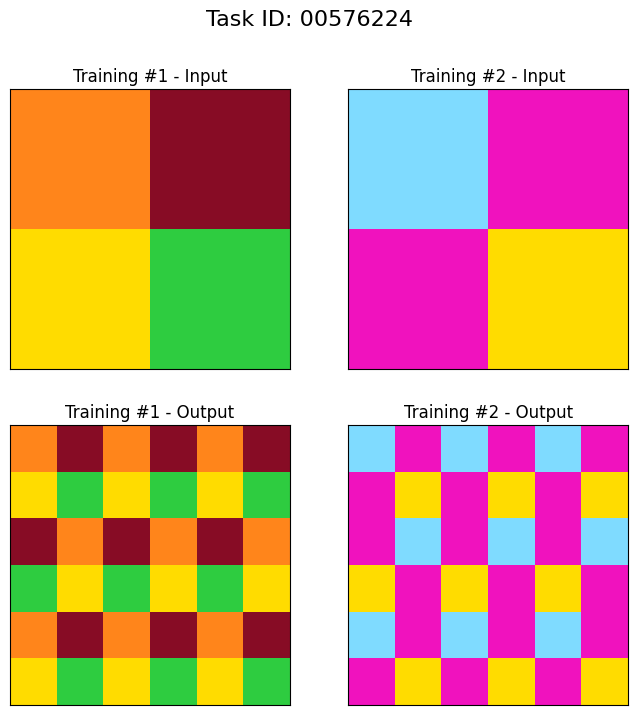

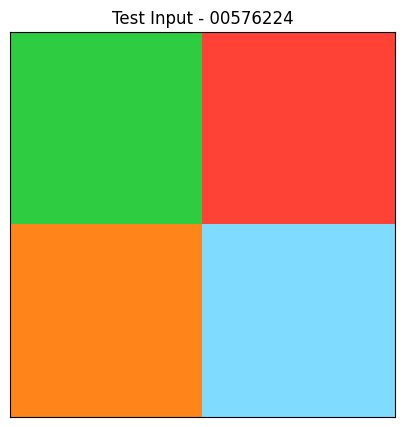

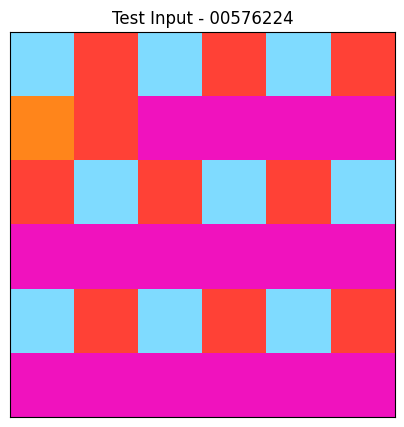

<Figure size 640x480 with 0 Axes>

In [13]:
import arc_visualizer as ArcVisualizer
import importlib
importlib.reload(ArcVisualizer)
import json
from pprint import pprint

# Load data directly from file
arc_challenge_file = './input/arc-prize-shrink/arc-agi_test_challenges.json'

# Load original data
arc_data = None
with open(arc_challenge_file, 'r') as f:
    arc_data = json.load(f)

task_id = list(arc_data.items())[0][0]
task_entry = list(arc_data.items())[0][1]
task_entry["test"][0]["output"] = ans
pprint(task_entry)
ArcVisualizer.visualize_arc_example(task_entry['train'], task_entry['test'], task_id)

# ArcVisualizer.plot(ans)